A example using SimPEG to run 3d Gravity inversion for a 2d data

In [1]:
# SimPEG functionality
from simpeg.potential_fields import gravity
from simpeg.utils import plot2Ddata, model_builder, download
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
)

# discretize functionality
from discretize import TensorMesh, TreeMesh
from discretize.utils import active_from_xyz

# Common Python functionality
import os
import numpy as np
from scipy.interpolate import griddata
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

mpl.rcParams.update({"font.size": 14})

In [2]:
# files to work with
topo_filename = 'example data/gravity_topo.txt'
data_filename = 'example data/gravity_data.obs'

In [3]:
# Load topography (xyz file)
topo_xyz = np.loadtxt(str(topo_filename))

# Load field data (xyz file)
dobs = np.loadtxt(str(data_filename))

In [4]:
# Define receiver locations and observed data
receiver_locations = dobs[:, 0:3]
dobs = dobs[:, -1]

In [5]:
maximum_anomaly = np.max(np.abs(dobs))
floor_uncertainty = 0.02 * maximum_anomaly
uncertainties = floor_uncertainty * np.ones(np.shape(dobs))
print("Floor uncertainty: {}".format(floor_uncertainty))

Floor uncertainty: 0.00037204


In [6]:
# Define the receivers. The data consist of vertical gravity anomaly measurements.
# The set of receivers must be defined as a list.
receiver_list = gravity.receivers.Point(receiver_locations, components="gz")
receiver_list = [receiver_list]

# Define the source field
source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Define the survey
survey = gravity.survey.Survey(source_field)

In [7]:
data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)

In [8]:
# Generate tensor mesh with top at z = 0 m
dh = 5.0  # minimum cell size
hx = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]  # discretization along x
hy = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]  # discretization along y
hz = [(dh, 5, -1.3), (dh, 15)]  # discretization along z
tensor_mesh = TensorMesh([hx, hy, hz], "CCN")

# Shift vertically to top same as maximum topography
tensor_mesh.origin += np.r_[0.0, 0.0, topo_xyz[:, -1].max()]

In [9]:
active_tensor_cells = active_from_xyz(tensor_mesh, topo_xyz)
n_tensor_active = int(active_tensor_cells.sum())

In [10]:
tensor_model_map = maps.IdentityMap(nP=n_tensor_active)

In [11]:
starting_tensor_model = 1e-6 * np.ones(n_tensor_active)
reference_tensor_model = np.zeros_like(starting_tensor_model)

In [12]:
# Map for ignoring inactive cells when plotting
tensor_plotting_map = maps.InjectActiveCells(tensor_mesh, active_tensor_cells, np.nan)

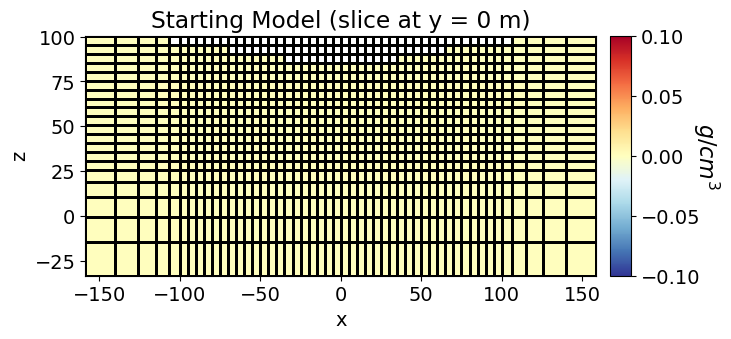

In [13]:
fig = plt.figure(figsize=(7, 3))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(vmin=-0.1, vmax=0.1)
tensor_mesh.plot_slice(
    tensor_plotting_map * starting_tensor_model,
    normal="Y",
    ax=ax1,
    ind=int(tensor_mesh.shape_cells[1] / 2),
    grid=True,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)
ax1.set_title("Starting Model (slice at y = 0 m)")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

plt.show()

In [14]:
simulation_L2 = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=tensor_mesh,
    rhoMap=tensor_model_map,
    ind_active=active_tensor_cells,
    engine="geoana",
)

In [15]:
dmis_L2 = data_misfit.L2DataMisfit(data=data_object, simulation=simulation_L2)

In [16]:
reg_L2 = regularization.WeightedLeastSquares(
    tensor_mesh,
    active_cells=active_tensor_cells,
    length_scale_x=1.0,
    length_scale_y=1.0,
    length_scale_z=1.0,
    reference_model=reference_tensor_model,
    reference_model_in_smooth=False,
)

In [17]:
opt_L2 = optimization.InexactGaussNewton(
    maxIter=100, maxIterLS=20, maxIterCG=10, tolCG=1e-2
)

In [18]:
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

In [19]:
sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=False)
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=1)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list_L2 = [
    sensitivity_weights,
    update_jacobi,
    starting_beta,
    beta_schedule,
    target_misfit,
]

In [20]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run inversion
recovered_tensor_model = inv_L2.run(starting_tensor_model)


Running inversion with SimPEG v0.22.1

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  9.44e+02  1.32e+04  1.20e-07  1.32e+04    4.37e+04      0              
   1  4.72e+02  1.82e+03  2.53e+00  3.01e+03    6.64e+03      0              
   2  2.36e+02  8.65e+02  3.94e+00  1.80e+03    4.32e+03      0   Skip BFGS  
   3  1.18e+02  3.59e+02  5.42e+00  9.99e+02    2.62e+03      0   Skip BFGS  
   4  5.90e+01  1.39e+02  6.70e+00  5.34e+02    1.50e+03      0   Skip BFGS  
   5  2.95e+01  5.26e+01  7.70e+00  2.80e+02    8.28e+02      0   Skip BFGS  
   6  1.48e+01  1.96e+0

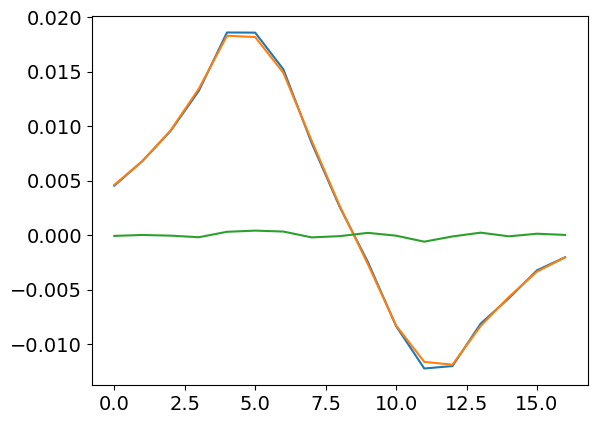

In [21]:
dpred = inv_prob_L2.dpred

plt.plot(dobs)
plt.plot(dpred)
plt.plot(dobs - dpred)


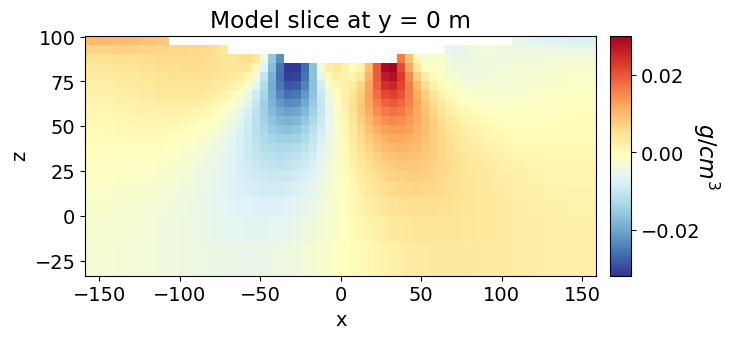

In [22]:
# Plot Recovered Model
fig = plt.figure(figsize=(7, 3))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(
    vmin=np.min(recovered_tensor_model), vmax=np.max(recovered_tensor_model)
)
tensor_mesh.plot_slice(
    tensor_plotting_map * recovered_tensor_model,
    normal="Y",
    ax=ax1,
    ind=int(tensor_mesh.shape_cells[1] / 2),
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)
ax1.set_title("Model slice at y = 0 m")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

plt.show()

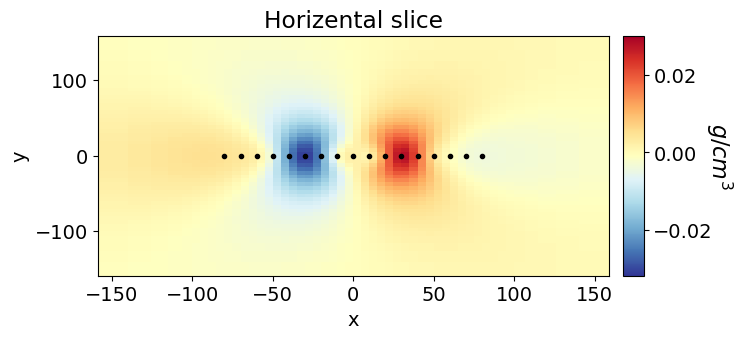

In [23]:
# Plot Recovered Model
fig = plt.figure(figsize=(7, 3))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(
    vmin=np.min(recovered_tensor_model), vmax=np.max(recovered_tensor_model)
)
tensor_mesh.plot_slice(
    tensor_plotting_map * recovered_tensor_model,
    normal="Z",
    ax=ax1,
    ind=int(tensor_mesh.shape_cells[2] / 2)+5,
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)
plt.plot(receiver_locations[:,0],receiver_locations[:,1],'k.')
ax1.set_title("Horizental slice")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

plt.show()